**revised notebook for final release**

This notebook is the second of 2 parts for the analysis of mouse data presented in **Figure 6**. This notebook ingests the location of nucleosomes (from DANPOS dpos, filtered and converted by `danpos-xls-process.py`), the nucleosome positioning track (from DANPOS dpos, pre-processed by the somewhat misnamed `wig2rle.R`), and PF binding sites (processed from FIMO results via `py3-motif-matching.ipynb`), and outputs the final figures (though the file-writing cells have been disabled).

**Warning** - this notebook requires significant computational resources and was originally run on a compute node of the Rockefeller High-Performance Computing environment. You should have at least 10 GB of RAM *available to the R kernel* (not just on the machine, as other programs will require their own memory) - most laptops will not have this much memory. I have observed my notebooks' memory usage peaking at as much as 80 GB of RAM (!).

I suspect that the main culprit is the `strandedDistanceByNearest` call. I welcome suggestions to improve its decidedly inefficient iterative algorithmic structure, which was regrettably necessary to handle NAs.

# various initialization steps

In [1]:
# for my sanity - map some function names that I think exist to what actually exist
nrows <- nrow
ncols <- ncol
len <- length

In [2]:
options(repr.plot.width=12, repr.plot.height=4)
options(warn=-1)

In [3]:
multiplot <- function(..., plotlist=NULL, cols) {
    # from Winston Chang's R Cookbook
    
    require(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # Make the panel
    plotCols = cols                          # Number of columns of plots
    plotRows = ceiling(numPlots/plotCols) # Number of rows needed, calculated from # of cols

    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(plotRows, plotCols)))
    vplayout <- function(x, y)
        viewport(layout.pos.row = x, layout.pos.col = y)

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
        curRow = ceiling(i/plotCols)
        curCol = (i-1) %% plotCols + 1
        print(plots[[i]], vp = vplayout(curRow, curCol ))
    }

}

In [4]:
library(extrafont)

Registering fonts with R


In [5]:
#library(tracktables)
library(rtracklayer)
library(HelloRanges)
library(BSgenome.Mmusculus.UCSC.mm9)
library(heatmaps)
library(ggplot2)

library(TxDb.Mmusculus.UCSC.mm9.knownGene)

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, w

In [6]:
library(viridis)

Loading required package: viridisLite


In [7]:
mouse_transcripts <- transcripts(TxDb.Mmusculus.UCSC.mm9.knownGene, columns=c("tx_id", "tx_name"))
mouse_transcripts <- keepStandardChromosomes(mouse_transcripts, pruning.mode = 'tidy')
# drop MT
mouse_transcripts <- mouse_transcripts[seqnames(mouse_transcripts) != "chrM"]
mouse_tss <- resize(mouse_transcripts, width=1, fix='start')

In [8]:
mm9info <- seqinfo(BSgenome.Mmusculus.UCSC.mm9)

In [9]:
mouse_tss_2000 <- resize(mouse_tss, width = 2000, fix='center')
mouse_tss_2000 <- trim(mouse_tss_2000)

# Whyte 2013 ChipSeq motifs

I generated peaks via MACS2 from data in Whyte 2013.

## load motif locations into bioconductor

general formula: genomic coordinate of a motif's start = genomic coordinate of a motif's peak window + FIMO-reported start coordinate - value of flanking DNA bp (generally 200) - 1 (due to 1-based indexing, likely in FIMO)

In [10]:
## from the py3 notebook "py3_motif-matching"

Whyte_motifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox-Oct_motifs.bed")
Whyte_outermotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox-Oct_outermotifs.bed")
Whyte_Soxmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox_motifs.bed")
Whyte_Octmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Oct_motifs.bed")

Whyte_tandemmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/tandem_motifs.bed")

In [11]:
## from the py3 notebook "py3_motif-matching"

EpiSC_motifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox-Oct_motifs.bed")
EpiSC_outermotifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox-Oct_outermotifs.bed")
EpiSC_Soxmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox_motifs.bed")
EpiSC_Octmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Oct_motifs.bed")

EpiSC_tandemmotifs <- import("~/SoxOct/mouse/EpiSC_chip/tandem_motifs.bed")

## define colors

In [12]:
safered <- "#920000"
safegreen <- "#009292"
safeviolet <- "#490092"

## define metametaplot

In [13]:
getvalues <- function(granges, width = 2000, track){
    motifwindow <- resize(granges, width = width, fix = 'center')
    
    htmap <- CoverageHeatmap(windows = motifwindow, track = track)
    
    plotdata <- colMeans(image(htmap))
    plotaxis <- 1:len(plotdata) - floor(width/2)
    df <- data.frame(x = plotaxis, y= plotdata)
    
    return (df)
}

In [14]:
Whyte_metametaplot <- function(track, mwidth, title=""){
    
    df1 <- getvalues(Whyte_Soxmotifs, width=mwidth, track=track)
    df2 <- getvalues(Whyte_Octmotifs, width=mwidth, track=track)
    
    #options(repr.plot.width=3, repr.plot.height=1)
    
    abs <- floor(mwidth/2)
    plt <- ggplot() + 
            geom_line(data = df1, aes(x = x, y = y, colour = "Sox2"), size=.8) +
            geom_line(data = df2, aes(x = x, y = y, colour = "Oct4"), size=.8) +
            scale_colour_manual(values=c(safegreen, safeviolet,safered), name=title) +
            theme_classic() +
            ylab("Average\nnucleosome occupancy") +
            xlab("Relative genomic position (bp)") +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.8))) +
            #ylim (40,90) +
            #ylim(40,60) +
            xlim(-abs, abs) +
            scale_x_continuous(minor_breaks = seq(-1029,1029, 147))
                       
    plt
    
    #options(repr.plot.width=3, repr.plot.height=3)
    
    return(plt)
}

In [15]:
EpiSC_metametaplot <- function(track, mwidth, title=""){
    
    df1 <- getvalues(EpiSC_Soxmotifs, width=mwidth, track=track)
    df2 <- getvalues(EpiSC_Octmotifs, width=mwidth, track=track)
    
    #options(repr.plot.width=3, repr.plot.height=1)
    
    abs <- floor(mwidth/2)
    plt <- ggplot() + 
            geom_line(data = df1, aes(x = x, y = y, colour = "Sox2"), size=.8) +
            geom_line(data = df2, aes(x = x, y = y, colour = "Oct4"), size=.8) +
            scale_colour_manual(values=c(safegreen, safeviolet,safered), name=title) +
            theme_classic() +
            ylab("Average\nnucleosome occupancy") +
            xlab("Relative genomic position (bp)") +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.8))) +
            #ylim (40,90) +
            #ylim(40,60) +
            xlim(-abs, abs) +
            scale_x_continuous(minor_breaks = seq(-1029,1029, 147))
                       
    plt
    
    #options(repr.plot.width=3, repr.plot.height=3)
    
    return(plt)
}

# load Teif MNase-seq data

## nucleosome track

In [16]:
mm_npos_p <- readRDS("~/SoxOct/danpos-res/pooled/mESC-MNAseseq.smooth.rle.RDS")

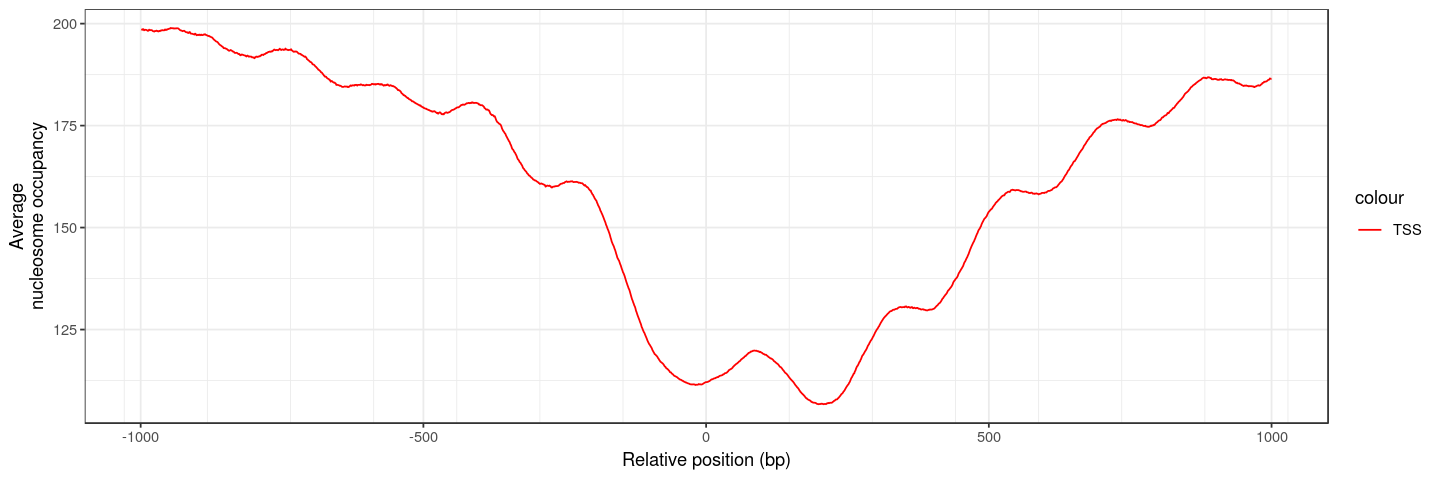

In [17]:
htmap_mm_tss_mnase <- CoverageHeatmap(windows = trim(mouse_tss_2000), track = mm_npos_p)

plotdata <- colMeans(image(htmap_mm_tss_mnase))
plotaxis <- 1:len(plotdata) - 1000
pltdf_mm_tss_mnase <- data.frame(x = plotaxis, y= plotdata)

plt <- ggplot() + 
    geom_line(data = pltdf_mm_tss_mnase, aes(x = x, y = y, colour = "TSS")) +
    #geom_line(data = pltdf4, aes(x = x, y = y, colour = "TSS")) +
    scale_colour_manual(values=c("red")) +
    #theme_classic() +
    theme_bw() +
    ylab("Average\nnucleosome occupancy") +
    xlab("Relative position (bp)") +
    #ylim (40,90) +
    #ylim(40,60) +
    #xlim(-200,200) +
    scale_x_continuous(minor_breaks = seq(-1029,1029, 147))

options(repr.plot.width=12, repr.plot.height=4)

plt

## nucleosome locations

In [18]:
# pooled

# read in the ranges
npeaks_m1_p <- import("~/SoxOct/danpos-res/pooled/mESC-MNaseseq.smooth.positions.bedgraph")

# resize the nucleosome peaks (DANPOS hard-codes them to be 140 bp)
npeaks_m1_p_c <- resize(npeaks_m1_p, width = 0, fix = "center")

# Figure 7B: aggregate nucleosome score

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


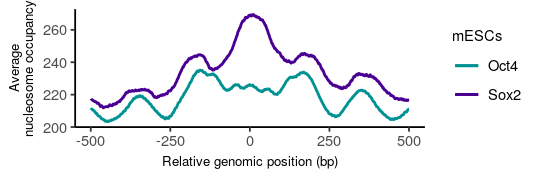

In [19]:
options(repr.plot.width=4.5, repr.plot.height=1.5)
Whyte_metametaplot(track = mm_npos_p, mwidth = 1000, title="mESCs")

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


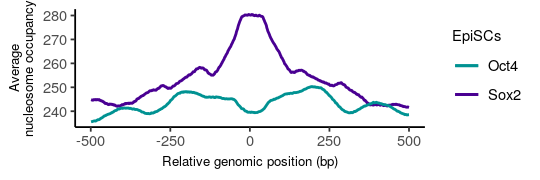

In [20]:
options(repr.plot.width=4.5, repr.plot.height=1.5)
EpiSC_metametaplot(track = mm_npos_p, mwidth = 1000, title="EpiSCs")
#ggsave(filename = "PanelB-2.eps", width = 4.5, height = 1.5, units = "in")

# Figure 7C-F: calculate distributions of distances

In [21]:
# resize the motif tracks to be tiny
Whyte_motifs_c      <- resize(Whyte_motifs,      width = 0, fix='center')
Whyte_outermotifs_c <- resize(Whyte_outermotifs, width = 0, fix='center')
Whyte_Soxmotifs_c   <- resize(Whyte_Soxmotifs,   width = 0, fix='center')
Whyte_Octmotifs_c   <- resize(Whyte_Octmotifs,   width = 0, fix='center')

Whyte_tandemmotifs_c <- resize(Whyte_tandemmotifs, width=0, fix='center')

## stranded Distance

### strandedDistanceByNearest function definition

In [22]:
strandedDistanceByNearest <- function(query, target){
    # gets (non absolute) distance for each item in query on target
    
    # calculate the distance:
    
    ## note that precede actually returns the item in subject that the target PRECEDES, not the other way around!
    #d_precede <- distance((target)[precede(subject = target, x = query)], query)
    ## you'd think the above would work, but annoyingly sometimes you get an NA, and then the subsetting dies...
    idx_precede <- precede(subject = target, x = query)
    d_precede <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_precede[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- distance(target[index],query[i])
        }
        
        d_precede[i] <- assign
    }
    
    ## the same goes for follow; the negation is so we correctly have negative distances
    #d_follow  <- -distance((target)[follow(subject = target, x = query)], query)
    
    idx_follow <- follow(subject = target, x = query)
    d_follow <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_follow[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- -distance(target[index],query[i]) # note that here is the negation!
        }
        
        d_follow[i] <- assign
    }
    
    # compare precede vs. follow
    # return the one with the biggest abs
    # if one of them is null, the other wins by default; if both are null, return NA
    # note that this is tremendously inelegant and likely to be slow!!!
    
    answer <- integer(length(query)) # pre-allocate a vector to make this less bad
    for (i in 1:length(query)){
        
        
        if (is.na(d_precede[i]) & !is.na(d_follow[i])){
        # only the follow number is valid
            select <- d_follow[i]
        } else if (!is.na(d_precede[i]) & is.na(d_follow[i])){
        # only the precede is valid
            select <- d_precede[i]
        } else if (is.na(d_precede[i]) & is.na(d_follow[i])){
        # somehow both are invalid??
            select <- NA
        } else {
        # both are presumably valid now
            if (abs(d_follow[i]) < d_precede[i]) {
                select <- d_follow[i]
            } else select <- d_precede[i]
            
        }
        answer[i] <- select
    }
    
    return (answer)
}

In [23]:
strandeddens <- function(data, filter = 150, bw = 2, color = "orchid4", linetype="solid"){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    plt <- ggplot() +
            #geom_histogram(df, aes(x=x, y=stat(density)), binwidth=1, fill = 'gray') +
            stat_density(data = df, aes(x=x), bw=bw, color = color, geom = 'line', linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            geom_vline(xintercept=-73, linetype='dotted') + 
            coord_cartesian(ylim = c(0,.006)) + 
            xlab("Relative position (bp)") +
            geom_vline(xintercept=0, linetype='dashed') +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.75))) + 
            theme(text = element_text(family = 'Arial'))

    plt 
    
    return (plt)
}

In [24]:
unstrandeddens <- function(data, filter = 150, bw = 2, color = "orchid4", linetype="solid"){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    # take the absolute value
    df <- abs(df)
    df <- rbind(df, data.frame(x=df[df$x ==0,])) # pads the zero position X2 
                                # since it should be doubled to match everything else
    
    plt <- ggplot() +
            #geom_histogram(df, aes(x=x, y=stat(density)), binwidth=1, fill = 'gray') +
            stat_density(data = df, aes(x=x), bw=bw, color = color, geom = 'line', 
                         linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            ##geom_vline(xintercept=-73, linetype='dotted') +
            #geom_vline(xintercept=31, linetype='dotted')  +
            #geom_vline(xintercept=36, linetype='dotted')  +
            #geom_vline(xintercept=40, linetype='dotted')  +
            #geom_vline(xintercept=64, linetype='dotted')  +
            #xlim(c(0,filter)) +
            coord_cartesian(ylim = c(0,.012)) + 
            xlab("Absolute position (bp)") +
            geom_vline(xintercept=0, linetype='dashed') +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.75))) + 
            theme(text = element_text(family = 'Arial'))

    plt 
    
    return (plt)
}

unstrandeddens2 <- function(data, filter = 150, bw = 2, color = "orchid4", linetype="solid"){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    # take the absolute value
    df <- abs(df)
    df <- rbind(df, data.frame(x=df[df$x ==0,])) # pads the zero position X2 
                                # since it should be doubled to match everything else
    
    nzeros <- len(df[df$x==0,]) # 
    pad_df <- data.frame(x=c(rep(-1,nzeros), 
                         rep(-2,nzeros),
                         rep(-3,nzeros),
                         rep(-4,nzeros),
                         rep(-5,nzeros),
                         rep(-6,nzeros),
                         rep(-7,nzeros),
                         rep(-8,nzeros),
                         rep(-9,nzeros)))
    df  <- rbind(df, pad_df)   # pad to avoid the blip down at zero
    
    nends <- len(df[df$x==filter,]) # 
    pad_df <- data.frame(x=c(rep(filter+1,nends), 
                         rep(filter+2,nends),
                         rep(filter+3,nends),
                         rep(filter+4,nends),
                         rep(filter+5,nends),
                         rep(filter+6,nends),
                         rep(filter+7,nends),
                         rep(filter+8,nends),
                         rep(filter+9,nends)))
    df  <- rbind(df, pad_df)   # pad to avoid the blip down at other side
    
    plt <- ggplot() +
            #geom_histogram(df, aes(x=x, y=stat(density)), binwidth=1, fill = 'gray') +
            stat_density(data = df, aes(x=x), bw=bw, color = color, geom = 'line', 
                         linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            ##geom_vline(xintercept=-73, linetype='dotted') +
            #geom_vline(xintercept=31, linetype='dotted')  +
            #geom_vline(xintercept=36, linetype='dotted')  +
            #geom_vline(xintercept=40, linetype='dotted')  +
            #geom_vline(xintercept=64, linetype='dotted')  +
            #xlim(c(0,filter)) +
            geom_rect(data=data.frame(xmin=-15, xmax=0, ymin=0, ymax=.012),
                      mapping=aes(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax),fill='white') +
                      # covers the left hand edge effect
            geom_rect(data=data.frame(xmin=filter, xmax=filter+50, ymin=0, ymax=.012),
                      mapping=aes(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax),fill='white') +
                      # covers the right hand edge effect
            coord_cartesian(ylim = c(0,.012),
                            xlim = c(0, filter)) + 
            xlab("Absolute position (bp)") +
            geom_vline(xintercept=0, linetype='dashed') +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.75))) + 
            theme(text = element_text(family = 'Arial'))

    plt 
    
    return (plt)
}


gm_mean = function(x, na.rm=TRUE){
    # from https://stackoverflow.com/questions/2602583/geometric-mean-is-there-a-built-in
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

unstrandeddens3 <- function(data, filter = 150, bw = 2, color = "orchid4", linetype="solid",
                            smoothleft=FALSE, smoothright=FALSE){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    # take the absolute value
    df <- abs(df)
    df <- rbind(df, data.frame(x=df[df$x ==0,])) # pads the zero position X2 
                                # since it should be doubled to match everything else
    if (smoothleft) {
        nzeros <- mean(
                        c(
                          len(df[df$x==0,]),
                          len(df[df$x==1,]),
                          len(df[df$x==2,]),
                          len(df[df$x==3,]),
                          len(df[df$x==4,]),
                          len(df[df$x==5,]),
                          len(df[df$x==6,])))
        #

        pad_df <- data.frame(x=c(rep(-1,nzeros), 
                             rep(-2,nzeros),
                             rep(-3,nzeros),
                             rep(-4,nzeros),
                             rep(-5,nzeros),
                             rep(-6,nzeros),
                             rep(-7,nzeros),
                             rep(-8,nzeros),
                             rep(-9,nzeros)))
    
        df  <- rbind(df, pad_df)   # pad to avoid the blip down at zero
    }
    
    if (smoothright){
        nends <- mean(
                        c(
                          len(df[df$x==filter  ,]),
                          len(df[df$x==filter-1,]),
                          len(df[df$x==filter-2,]),
                          len(df[df$x==filter-3,]),
                          len(df[df$x==filter-4,]),
                          len(df[df$x==filter-5,]),
                          len(df[df$x==filter-6,])))

        #nends <- len(df[df$x==filter,]) # 
        pad_df <- data.frame(x=c(rep(filter+1,nends), 
                             rep(filter+2,nends),
                             rep(filter+3,nends),
                             rep(filter+4,nends),
                             rep(filter+5,nends),
                             rep(filter+6,nends),
                             rep(filter+7,nends),
                             rep(filter+8,nends),
                             rep(filter+9,nends)))
        df  <- rbind(df, pad_df)   # pad to avoid the blip down at other side
    }

    plt <- ggplot() +
            #geom_histogram(df, aes(x=x, y=stat(density)), binwidth=1, fill = 'gray') +
            stat_density(data = df, aes(x=x), bw=bw, color = color, geom = 'line', 
                         linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            ##geom_vline(xintercept=-73, linetype='dotted') +
            #geom_vline(xintercept=31, linetype='dotted')  +
            #geom_vline(xintercept=36, linetype='dotted')  +
            #geom_vline(xintercept=40, linetype='dotted')  +
            #geom_vline(xintercept=64, linetype='dotted')  +
            #xlim(c(0,filter)) +
            coord_cartesian(ylim = c(0,.012),
                            xlim = c(0, filter)) + 
            xlab("Absolute position (bp)") +
            geom_vline(xintercept=0, linetype='dashed') +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.75))) + 
            theme(text = element_text(family = 'Arial'))

    
    if (smoothleft)   {plt <- plt + geom_rect(data=data.frame(xmin=-15, xmax=0, ymin=0, ymax=.012),
                      mapping=aes(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax),fill='white')}
                      # covers the left hand extension from smoothing
    if (smoothright) {plt <- plt + geom_rect(data=data.frame(xmin=filter, xmax=filter+50, ymin=0, ymax=.012),
                      mapping=aes(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax),fill='white')}
                      # covers the right hand extension from smoothing
    plt 
    
    return (plt)
}

unstrandeddens4 <- function(data, filter = 150, bw = 2, color = "orchid4", linetype="solid",
                            smoothleft=FALSE, smoothright=FALSE){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    # take the absolute value
    df <- abs(df)
    df <- rbind(df, data.frame(x=df[df$x ==0,])) # pads the zero position X2 
                                # since it should be doubled to match everything else
    if (smoothleft) {
        nzeros <- mean(
                        c(
                          len(df[df$x==0,]),
                          len(df[df$x==1,]),
                          len(df[df$x==2,]),
                          len(df[df$x==3,]),
                          len(df[df$x==4,]),
                          len(df[df$x==5,]),
                          len(df[df$x==6,])))
        #

        pad_df <- data.frame(x=c(rep(-1,nzeros), 
                             rep(-2,nzeros),
                             rep(-3,nzeros),
                             rep(-4,nzeros),
                             rep(-5,nzeros),
                             rep(-6,nzeros),
                             rep(-7,nzeros),
                             rep(-8,nzeros),
                             rep(-9,nzeros)))
    
        df  <- rbind(df, pad_df)   # pad to avoid the blip down at zero
    }
    
    if (smoothright){
        nends <- mean(
                        c(
                          len(df[df$x==filter  ,]),
                          len(df[df$x==filter-1,]),
                          len(df[df$x==filter-2,]),
                          len(df[df$x==filter-3,]),
                          len(df[df$x==filter-4,]),
                          len(df[df$x==filter-5,]),
                          len(df[df$x==filter-6,])))

        #nends <- len(df[df$x==filter,]) # 
        pad_df <- data.frame(x=c(rep(filter+1,nends), 
                             rep(filter+2,nends),
                             rep(filter+3,nends),
                             rep(filter+4,nends),
                             rep(filter+5,nends),
                             rep(filter+6,nends),
                             rep(filter+7,nends),
                             rep(filter+8,nends),
                             rep(filter+9,nends)))
        df  <- rbind(df, pad_df)   # pad to avoid the blip down at other side
    }

    smoothdens <- density(df$x, bw=bw)
    
    smoothdata <- data.frame(x=smoothdens$x, y=smoothdens$y)
    
    plt <- ggplot(data=smoothdata) +
            geom_line(aes(x=x, y=y), color = color,  
                         linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            ##geom_vline(xintercept=-73, linetype='dotted') +
            #geom_vline(xintercept=31, linetype='dotted')  +
            #geom_vline(xintercept=36, linetype='dotted')  +
            #geom_vline(xintercept=40, linetype='dotted')  +
            #geom_vline(xintercept=64, linetype='dotted')  +
            xlim(c(0,filter)) +
            coord_cartesian(ylim = c(0,.012),
                            xlim = c(0, filter)) + 
            xlab("Distance from dyad (bp)") +
            ylab("Density") +
            geom_vline(xintercept=0, linetype='dashed') +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.75))) + 
            theme(text = element_text(family = 'Arial'))

    plt 
    
    return (plt)
}

In [25]:
Whyte_std_Soxmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox_motifs.strand.bed")
Whyte_std_Soxmotifs_c <- resize(Whyte_std_Soxmotifs, width=0, fix='center')

Whyte_std_Octmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Oct_motifs.strand.bed")
Whyte_std_Octmotifs_c <- resize(Whyte_std_Octmotifs, width=0, fix='center')

In [26]:
EpiSC_std_Soxmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox_motifs.strand.bed")
EpiSC_std_Soxmotifs_c <- resize(EpiSC_std_Soxmotifs, width=0, fix='center')

EpiSC_std_Octmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Oct_motifs.strand.bed")
EpiSC_std_Octmotifs_c <- resize(EpiSC_std_Octmotifs, width=0, fix='center')

### exclude overlaps (2 peaks within 200 bp)

In [27]:
Whyte_std_Soxmotifs_200 <- resize(Whyte_std_Soxmotifs, width = 200, fix='center')
Whyte_std_Octmotifs_200 <- resize(Whyte_std_Octmotifs, width = 200, fix='center')

EpiSC_std_Soxmotifs_200 <- resize(EpiSC_std_Soxmotifs, width = 200, fix='center')
EpiSC_std_Octmotifs_200 <- resize(EpiSC_std_Octmotifs, width = 200, fix='center')

Whyte_overlaps <- subsetByOverlaps(Whyte_std_Soxmotifs_200, Whyte_std_Octmotifs_200)
print(c(len(Whyte_overlaps), len(Whyte_std_Soxmotifs), len(Whyte_std_Octmotifs)))

EpiSC_overlaps <- subsetByOverlaps(EpiSC_std_Soxmotifs_200, EpiSC_std_Octmotifs_200)
print(c(len(EpiSC_overlaps), len(EpiSC_std_Soxmotifs), len(EpiSC_std_Octmotifs)))

[1]  417 4619 8345
[1]   319 36576 63008


In [28]:
Whyte_std_Soxmotifs <- Whyte_std_Soxmotifs[!Whyte_std_Soxmotifs_200 %in% Whyte_overlaps]
Whyte_std_Octmotifs <- Whyte_std_Octmotifs[!Whyte_std_Octmotifs_200 %in% Whyte_overlaps]

Whyte_std_Soxmotifs_c <- resize(Whyte_std_Soxmotifs, width=0, fix='center')
Whyte_std_Octmotifs_c <- resize(Whyte_std_Octmotifs, width=0, fix='center')

EpiSC_std_Soxmotifs <- EpiSC_std_Soxmotifs[!EpiSC_std_Soxmotifs_200 %in% EpiSC_overlaps]
EpiSC_std_Octmotifs <- EpiSC_std_Octmotifs[!EpiSC_std_Octmotifs_200 %in% EpiSC_overlaps]

EpiSC_std_Soxmotifs_c <- resize(EpiSC_std_Soxmotifs, width=0, fix='center')
EpiSC_std_Octmotifs_c <- resize(EpiSC_std_Octmotifs, width=0, fix='center')

### distance calculation

**warning** -- the `strandedDistanceByNearest` function is quite slow - expect this to take a while. Maybe go get a cup of coffee and check your email.

In [29]:
#dist_strand_m1_p     <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = Whyte_std_tandemmotifs_c)
dist_strand_m1_p_Sox <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = Whyte_std_Soxmotifs_c)
dist_strand_m1_p_Oct <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = Whyte_std_Octmotifs_c)

In [30]:
#dist_Epi_strand_m1_p_tandem  <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = EpiSC_std_tandemmotifs_c)
dist_Epi_strand_m1_p_Sox     <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = EpiSC_std_Soxmotifs_c)
dist_Epi_strand_m1_p_Oct     <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = EpiSC_std_Octmotifs_c)

## render panels 7C-F

Loading required package: grid


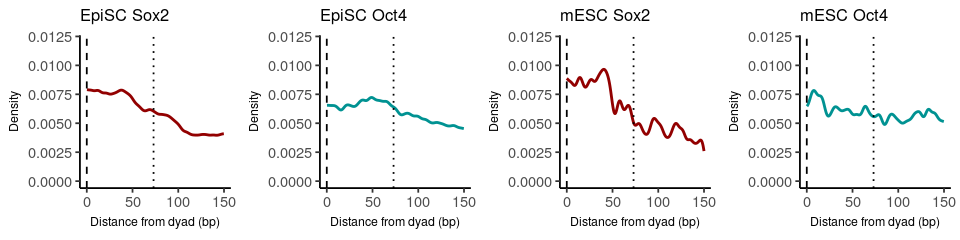

In [31]:
plt_EpiSox <- unstrandeddens4(dist_Epi_strand_m1_p_Sox, filter = 150, bw =3,
                         smoothleft = TRUE, smoothright = TRUE, color=safered   ) +ggtitle('EpiSC Sox2') 
plt_EpiOct <- unstrandeddens4(dist_Epi_strand_m1_p_Oct, filter = 150, bw =3,
                         smoothleft = TRUE, smoothright = TRUE, color=safegreen ) +ggtitle('EpiSC Oct4')# +xlab("Relative position (bp)")

plt_ESCSox <- unstrandeddens4(dist_strand_m1_p_Sox, filter = 150, bw =3, 
                         smoothleft=TRUE,  smoothright=FALSE, color=safered   ) +ggtitle('mESC Sox2')
plt_ESCOct <- unstrandeddens4(dist_strand_m1_p_Oct, filter = 150, bw =3, 
                         smoothleft=TRUE, smoothright=TRUE, color=safegreen ) +ggtitle('mESC Oct4') # +xlab("Relative position (bp)") 

options(repr.plot.width=8, repr.plot.height=2)
multiplot( plt_EpiSox, 
           plt_EpiOct, 
           plt_ESCSox, 
           plt_ESCOct, cols = 4)
options(repr.plot.width=6, repr.plot.height=2)

# Statistical tests

## helper functions

In [32]:
# helper functions

mass <- function(dist, filter){
    # takes a raw vector -- i.e. a raw dataset of distances -- and converts it to a freq table
    df = data.frame(x=dist)
    df = df[abs(df$x) <= filter,]
    
    return (as.data.frame(table(df), stringsAsFactors = FALSE))
}

In [33]:
filterData <- function(dataset, minbound, maxbound){
    
    filter <- max(abs(minbound),abs(maxbound))
    
    counts <- mass(dataset, filter=filter)
    
    retval <- counts[as.numeric(counts$df) >= minbound & as.numeric(counts$df) <= maxbound,]
    return (retval)
}

In [34]:
unstrand <- function(data, filter = 150){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    # take the absolute value
    df <- abs(df)
    df <- rbind(df, data.frame(x=df[df$x ==0,]))
    
    return (df)
}

## t-tests

In [35]:
#wrapper function for convenience and pretty printing
t_test_wrap_unstrand <- function(dataset, window=13){

    res <- t.test(filterData(dataset, minbound = 0, maxbound = (window-1))$Freq, 
                   filterData(dataset, minbound = 36-floor((window-1)/2), 
                              maxbound = 36+ceiling((window-1)/2))$Freq)$p.value
    print(c("1/4 vs. dyad:", res))
    
    res <- t.test(filterData(dataset, minbound =  73 - (window-1), maxbound = 73)$Freq, 
                   filterData(dataset, minbound = 36-floor((window-1)/2), 
                              maxbound = 36+ceiling((window-1)/2))$Freq)$p.value
    print(c("1/4 vs. edge:", res))
    
    res <- t.test(filterData(dataset, minbound =  73 - (window-1), maxbound = 73)$Freq, 
                   filterData(dataset, minbound = 0, maxbound = (window-1))$Freq)$p.value
    print(c("dyad vs. edge:", res))
}

In [36]:
window=13

print("Sox mEpiSCs")
t_test_wrap_unstrand(unstrand(dist_Epi_strand_m1_p_Sox), window=window)
print("Oct mEpiSCs")
t_test_wrap_unstrand(unstrand(dist_Epi_strand_m1_p_Oct), window=window)

print("Sox mESCs")
t_test_wrap_unstrand(unstrand(dist_strand_m1_p_Sox), window=window)
print("Oct mESCs")
t_test_wrap_unstrand(unstrand(dist_strand_m1_p_Oct), window=window)

[1] "Sox mEpiSCs"
[1] "1/4 vs. dyad:"     "0.545660044711505"
[1] "1/4 vs. edge:"        "1.20475690783332e-05"
[1] "dyad vs. edge:"       "3.60049173900595e-07"
[1] "Oct mEpiSCs"
[1] "1/4 vs. dyad:"     "0.164782632764695"
[1] "1/4 vs. edge:"     "0.539136827308958"
[1] "dyad vs. edge:"    "0.472564464504114"
[1] "Sox mESCs"
[1] "1/4 vs. dyad:"     "0.563336452587995"
[1] "1/4 vs. edge:"      "0.0024440732186062"
[1] "dyad vs. edge:"      "0.00269856337972238"
[1] "Oct mESCs"
[1] "1/4 vs. dyad:"     "0.110863274268934"
[1] "1/4 vs. edge:"     "0.685512311362539"
[1] "dyad vs. edge:"     "0.0727058084230916"


In [37]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.2 (Maipo)

Matrix products: default
BLAS/LAPACK: /rugpfs/fs0/zhao_lab/scratch/ezheng/.store/.miniconda3/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] viridis_0.5.1                          
 [2] viridisLite_0.3.0                      
 [3] TxDb.Mmusculus.UCSC.mm9.knownGene_3.2.2
 [4] ggplot2_3.1.1                          
 [5] heatmaps_1.6.0                         
 [6] BSgenome.Mmusculus.UCSC.mm9_1.4.0      
 [7] HelloRanges_1.8.0                      
 [8] GenomicAlignments_1.18.1               
 [9] VariantAnnotation_1.28.13              
[10] Rsamtools_1.34.1                       
[11] SummarizedExperiment_1.12.0            
[12] DelayedArray_0.8.0                     
[13] BiocParallel_1.16.